In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## configuration

embedding_size = 300 
max_features = 120000 
max_len = 750 
batch_size = 512 
n_epochs = 20
debug = 0

dataset_path = "/content/drive/MyDrive/Datasets/hateXplain/"
data_filename = 'dataset.json'
class_labels_filename = 'classes.npy'


In [3]:
'''
Convert json data to a dataframe
1. convert json to dataframe
2. Voting resolution
3. Remove text samples that have 'undecided' class label
'''

import pandas as pd
import numpy as np
import json

def get_data(dataset_path, data_filename, class_labels_filename):

  data_path = dataset_path + data_filename
  class_labels_path = dataset_path + class_labels_filename

  with open(data_path, 'r') as f:
    data = json.load(f)
  data_dictionary = []
  for key in data:
    buffer = {}
    buffer['post'] = data[key]['post_tokens']
    final_label = []

    for i in range(1, 4):
      final_label.append(data[key]['annotators'][i-1]['label'])
    
    final_label_id = max(final_label, key = final_label.count)
    buffer['rationales'] = data[key]['rationales']

    if(final_label.count(final_label_id) == 1):
      continue
    else:
      buffer['label'] = final_label_id
    
    data_dictionary.append(buffer)
  return pd.DataFrame(data_dictionary)

In [4]:
data = get_data(dataset_path=dataset_path, data_filename=data_filename, class_labels_filename=class_labels_filename)


In [5]:
data.head()	

,post,rationales,label
0,"[i, dont, think, im, getting, my, baby, them, ...",[],normal
1,"[we, cannot, continue, calling, ourselves, fem...",[],normal
2,"[nawt, yall, niggers, ignoring, me]",[],normal
3,"[<user>, i, am, bit, confused, coz, chinese, p...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",hatespeech
4,"[this, bitch, in, whataburger, eating, a, burg...","[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",hatespeech


In [6]:
one_hot = pd.get_dummies(data['label'])
data = data.drop('label',axis = 1)
data = data.join(one_hot)

In [7]:
cleaned_posts = []

for index, row in data.iterrows():
  post = row['post']
  post_str = ''
  for word in post:
    post_str = post_str + word + ' '
    
  cleaned_posts.append(post_str)

data['posts'] = cleaned_posts
  

In [8]:
data = data.drop(['post'], axis = 1)

In [9]:
data.head()

,rationales,hatespeech,normal,offensive,posts
0,[],0,1,0,i dont think im getting my baby them white 9 h...
1,[],0,1,0,we cannot continue calling ourselves feminists...
2,[],0,1,0,nawt yall niggers ignoring me
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,0,0,<user> i am bit confused coz chinese ppl can n...
4,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,0,0,this bitch in whataburger eating a burger with...


In [10]:
y_cols = list(data.columns[1:4])
print(y_cols)
is_multilabel = (data[y_cols].sum(axis=1) >1).count()

['hatespeech', 'normal', 'offensive']


In [11]:
def get_class_weight(data):
    class_weight = {}
    for num,col in enumerate(y_cols):
        if num not in class_weight:
            class_weight[col] = round((data[data[col] == 1][col].sum())/data.shape[0]*100,2)
    return class_weight
class_weight = get_class_weight(data)
print('Total class weight: ', sum(class_weight.values()), '%\n\n', class_weight)

Total class weight:  100.0 %

 {'hatespeech': 30.86, 'normal': 40.64, 'offensive': 28.5}


In [12]:
from sklearn.model_selection import train_test_split
def get_train_test_val(data):
    X_data = data['posts'].values
    y_data = data[list(data.columns[1:4])].values
    X, X_test, y, y_test = train_test_split(X_data, y_data, test_size=0.1, train_size=0.9)
    X_train = X
    y_train = y

    print(
        'X_train shape', X_train.shape,
        '\ny_train shape', y_train.shape,
        '\nX_test shape', X_test.shape,
        '\ny_test shape', y_test.shape,
    )
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_val(data)

X_train shape (17306,) 
y_train shape (17306, 3) 
X_test shape (1923,) 
y_test shape (1923, 3)


In [13]:
y_train[0]

array([0, 1, 0], dtype=uint8)

### Text Preprocessing

In [14]:
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [15]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
REPLACE_IP_ADDRESS = re.compile(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b')

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.replace('\n', ' ').lower()# lowercase text
    text = REPLACE_IP_ADDRESS.sub('', text) # remove ip address
    text = REPLACE_BY_SPACE_RE.sub(' ',text)# replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('',text)# delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join([w for w in text.split() if not w in STOPWORDS])# delete stopwords from text
    return text

X_train = [text_prepare(x) for x in X_train]
X_test = [text_prepare(x) for x in X_test]
X_train[:1]

['kim lip dykes']

### Bag of Words Model

In [16]:
from scipy import sparse as sp_sparse


In [17]:
# Dictionary of all words from train corpus with their counts.
words_counts = {}
for comments in X_train:
    for word in comments.split():
        if word not in words_counts:
            words_counts[word] = 1
        words_counts[word] += 1
        
DICT_SIZE = 10000
POPULAR_WORDS = sorted(words_counts, key=words_counts.get, reverse=True)[:DICT_SIZE]
WORDS_TO_INDEX = {key: rank for rank, key in enumerate(POPULAR_WORDS, 0)}
INDEX_TO_WORDS = {index:word for word, index in WORDS_TO_INDEX.items()}
ALL_WORDS = WORDS_TO_INDEX.keys()

In [18]:
def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    for word in text.split(' '):
        if word in words_to_index:
            result_vector[words_to_index[word]] +=1
    return result_vector

X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape, '\nX_test shape ', X_test_mybag.shape)

X_train shape  (17306, 10000) 
X_test shape  (1923, 10000)


In [19]:
POPULAR_WORDS[:10]


['user',
 'white',
 'number',
 'like',
 'nigger',
 'people',
 'women',
 'get',
 'jews',
 'one']

### TF-IDF

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_features(X_train, X_test):
    # Create TF-IDF vectorizer with a proper parameters choice
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=5)#, token_pattern='(\S+)')
    # Fit the vectorizer on the train set
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    # Transform the train, test set and return the result
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    
    return X_train_tfidf, X_test_tfidf, tfidf_vectorizer.vocabulary_

X_train_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

### Classifier

In [21]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

def train_classifier(X_train, y_train, C, regularisation):
    
    # Create and fit LogisticRegression wrapped into OneVsRestClassifier.

    model = OneVsRestClassifier(LogisticRegression(penalty=regularisation, C=C, max_iter=10000)).fit(X_train, y_train)
    return model

classifier_mybag = train_classifier(X_train_mybag, y_train, C = 4, regularisation = 'l2')
classifier_tfidf = train_classifier(X_train_tfidf, y_train, C = 4, regularisation = 'l2')

y_test_predicted_labels_mybag = classifier_mybag.predict(X_test_mybag)
y_test_predicted_labels_tfidf = classifier_tfidf.predict(X_test_tfidf)


In [22]:

# y_test_predicted_scores_mybag = classifier_mybag.decision_function(X_test_mybag)
# y_test_predicted_scores_tfidf = classifier_tfidf.decision_function(X_test_tfidf)


Text(69.0, 0.5, 'Actual_labels')

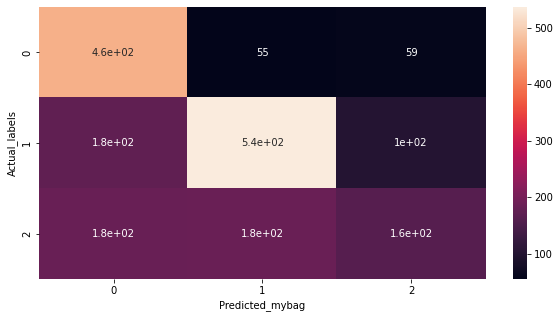

In [23]:
'''
  Confusion Matrix for BoW Method
'''

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(
    y_test.argmax(axis=1), y_test_predicted_labels_mybag.argmax(axis=1))

import seaborn as sns
plt.subplots(figsize=(10,5))
sns.heatmap(confusion_mat, annot=True)
plt.xlabel('Predicted_mybag')
plt.ylabel('Actual_labels')

Text(69.0, 0.5, 'Actual_labels')

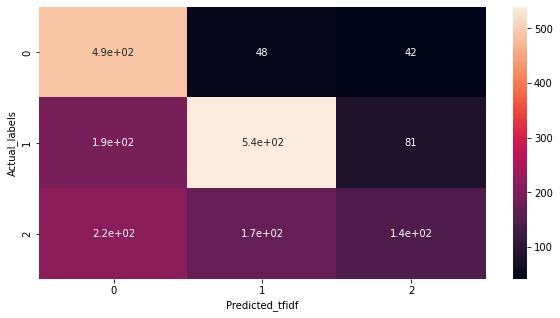

In [24]:
'''
  Confusion Matrix for TF-IDF Method
'''

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(
    y_test.argmax(axis=1), y_test_predicted_labels_tfidf.argmax(axis=1))

import seaborn as sns
plt.subplots(figsize=(10,5))
sns.heatmap(confusion_mat, annot=True)
plt.xlabel('Predicted_tfidf')
plt.ylabel('Actual_labels')

### Evaluation on TEST DATA

In [26]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [27]:
classifier_mybag = train_classifier(X_train_mybag, y_train, C = 50, regularisation = 'l2')

y_test_predicted_labels_mybag = classifier_mybag.predict(X_test_mybag)

def print_evaluation_scores(y_test, predicted):
    
    print('Accuracy: ', accuracy_score(y_test, predicted, normalize=True))
    print('F1-score macro: ', f1_score(y_test, predicted, average='macro'))
    print('F1-score micro: ', f1_score(y_test, predicted, average='micro'))
    print('F1-score weighted: ', f1_score(y_test, predicted, average='weighted'))
    print('Precision macro: ', average_precision_score(y_test, predicted, average='macro'))
    print('Precision micro: ', average_precision_score(y_test, predicted, average='micro'))
    print('Precision weighted: ', average_precision_score(y_test, predicted, average='weighted'))
    
print('Bag-of-words\n')
print_evaluation_scores(y_test, y_test_predicted_labels_mybag)


Bag-of-words

Accuracy:  0.4420176807072283
F1-score macro:  0.5395270067847387
F1-score micro:  0.5547140245494907
F1-score weighted:  0.5535629518651536
Precision macro:  0.45240286350499864
Precision micro:  0.456959684473423
Precision weighted:  0.46739392317660533


In [28]:
y_test_predicted_labels_mybag

array([[0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0]])

In [30]:
classifier_tfidf = train_classifier(X_train_tfidf, y_train, C = 50, regularisation = 'l2')

y_test_predicted_labels_tfidf = classifier_tfidf.predict(X_test_tfidf)

def print_evaluation_scores(y_test, predicted):
    
    print('Accuracy: ', accuracy_score(y_test, predicted, normalize=True))
    print('F1-score macro: ', f1_score(y_test, predicted, average='macro'))
    print('F1-score micro: ', f1_score(y_test, predicted, average='micro'))
    print('F1-score weighted: ', f1_score(y_test, predicted, average='weighted'))
    print('Precision macro: ', average_precision_score(y_test, predicted, average='macro'))
    print('Precision micro: ', average_precision_score(y_test, predicted, average='micro'))
    print('Precision weighted: ', average_precision_score(y_test, predicted, average='weighted'))
    
print('TF-IDF\n')
print_evaluation_scores(y_test, y_test_predicted_labels_tfidf)


TF-IDF

Accuracy:  0.49349973998959956
F1-score macro:  0.5799524440177798
F1-score micro:  0.5909580193756728
F1-score weighted:  0.5885371909140918
Precision macro:  0.4901128308693397
Precision micro:  0.49266503844760595
Precision weighted:  0.49828192669385346
